# Useful Resources

- https://arxiv.org/pdf/1801.06146.pdf
- https://arxiv.org/pdf/1705.02364.pdf
- https://github.com/radoslawkrolikowski/sentiment-analysis-pytorch
- https://www.kaggle.com/code/affand20/imdb-with-pytorch

# Prepare

In [ ]:
!pip install -q datasets
!pip install -q tqdm
!pip install -q seaborn
!pip install -q scikit-learn
!pip install -q pytorch_lightning
!pip install -q git+https://github.com/MagedSaeed/tkseem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 44.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.0 MB/s eta 

In [ ]:
import re
import os
import random
import string
import shutil
from pathlib import Path

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import torchmetrics

from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import LightningModule,Trainer
from pytorch_lightning.callbacks import EarlyStopping,LearningRateMonitor,ModelCheckpoint

import datasets
import seaborn as sns
import matplotlib.pyplot as plt


import tkseem as tk
from tqdm.auto import tqdm

In [ ]:
seed = 42

In [ ]:
# random.seed(seed)     # python random generator
# np.random.seed(seed)  # numpy random generator

# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

seed_everything(seed)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [ ]:
tqdm.pandas()

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Load and explore the dataset

In [ ]:
dataset = datasets.load_dataset("imdb")
dataset

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Converting to Pandas and droping duplicates

In [ ]:
train_dataset = dataset['train'].to_pandas()
train_dataset

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


In [ ]:
train_dataset = train_dataset.drop_duplicates(subset=['text'],keep='first').copy()
train_dataset

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


In [ ]:
test_dataset = dataset['test'].to_pandas()
test_dataset

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0
...,...,...
24995,Just got around to seeing Monster Man yesterda...,1
24996,I got this as part of a competition prize. I w...,1
24997,I got Monster Man in a box set of three films ...,1
24998,"Five minutes in, i started to feel how naff th...",1


In [ ]:
test_dataset = test_dataset.drop_duplicates(subset=['text'],keep='first').copy()
test_dataset

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0
...,...,...
24995,Just got around to seeing Monster Man yesterda...,1
24996,I got this as part of a competition prize. I w...,1
24997,I got Monster Man in a box set of three films ...,1
24998,"Five minutes in, i started to feel how naff th...",1


Count positives and negatives

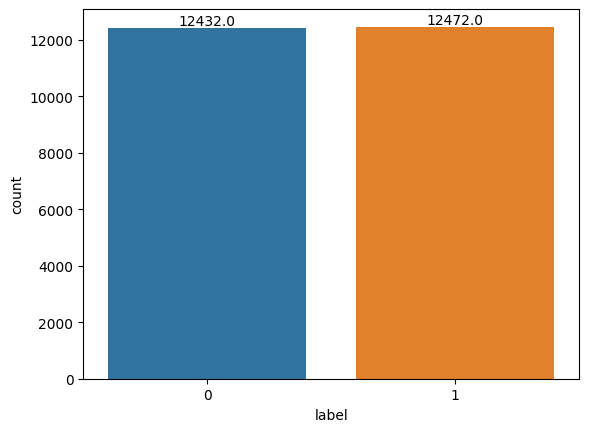

In [ ]:
# Create a count plot
ax = sns.countplot(data=train_dataset, x='label')
# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

trainset vocabulary and tokens count:


In [ ]:
vocabs_dict = {}
for document in train_dataset['text']:
  for word in document.split():
    vocabs_dict[word] = vocabs_dict.get(word,0)+1
f'{len(vocabs_dict.keys()):,}',f'{sum(vocabs_dict.values()):,}'

('280,617', '5,827,678')

# Clean and Preprocess the dataset

In [ ]:
# text cleaning

def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

# handle case like "shut up okay?Im only 10 years old"
# become "shut up okay Im only 10 years old"
def rm_punct2(text):
    return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    # return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    # return text.translate(str.maketrans('', '', string.punctuation))

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)     # add whitespaces between punctuation
    s = re.sub(r'\s{2,}', ' ', s)        # remove double whitespaces    
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):    
    text = rm_link(text)
    text = rm_html(text)
    text = space_bt_punct(text)
    text = rm_punct2(text)
    text = rm_number(text)
    text = rm_whitespaces(text)
    text = rm_nonascii(text)
    text = rm_emoji(text)
    text = spell_correction(text)
    return text

In [ ]:
clean_pipeline('the hello world .')

'the hello world '

In [ ]:
# preprocessing
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()    
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # make sure lemmas does not contains sotpwords
    return rm_stopwords(lemmas)
    # return lemmas # let us say that we need the stop words :)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    tokens = rm_stopwords(tokens)
    tokens = lemmatize(tokens)
    return ' '.join(tokens)

def prepare(text):
  return preprocess_pipeline(clean_pipeline(text))

In [ ]:
# test the prepare method
prepare('the good, the bad, and the ugly!')

'good bad ugly'

In [ ]:
train_dataset['processed'] = list(train_dataset['text'].progress_apply(prepare))
train_dataset

  0%|          | 0/24904 [00:00<?, ?it/s]

,text,label,processed
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,I rented I AM CURIOUS YELLOW video store contr...
1,"""I Am Curious: Yellow"" is a risible and preten...",0,I Am Curious Yellow risible pretentious steami...
2,If only to avoid making this type of film in t...,0,If avoid making type film future This film int...
3,This film was probably inspired by Godard's Ma...,0,This film probably inspired Godard Masculin fm...
4,"Oh, brother...after hearing about this ridicul...",0,Oh brother hearing ridiculous film umpteen yea...
...,...,...,...
24995,A hit at the time but now better categorised a...,1,A hit time better categorised Australian cult ...
24996,I love this movie like no other. Another time ...,1,I love movie like Another time I try explain v...
24997,This film and it's sequel Barry Mckenzie holds...,1,This film sequel Barry Mckenzie hold two great...
24998,'The Adventures Of Barry McKenzie' started lif...,1,The Adventures Of Barry McKenzie started life ...


In [ ]:
test_dataset['processed'] = test_dataset['text'].progress_apply(prepare)
test_dataset

  0%|          | 0/24801 [00:00<?, ?it/s]

,text,label,processed
0,I love sci-fi and am willing to put up with a ...,0,I love sci fi willing put lot Sci fi movie TV ...
1,"Worth the entertainment value of a rental, esp...",0,Worth entertainment value rental especially li...
2,its a totally average film with a few semi-alr...,0,totally average film semi alright action seque...
3,STAR RATING: ***** Saturday Night **** Friday ...,0,STAR RATING Saturday Night Friday Night Friday...
4,"First off let me say, If you haven't enjoyed a...",0,First let say If enjoyed Van Damme movie since...
...,...,...,...
24995,Just got around to seeing Monster Man yesterda...,1,Just got around seeing Monster Man yesterday I...
24996,I got this as part of a competition prize. I w...,1,I got part competition prize I watched really ...
24997,I got Monster Man in a box set of three films ...,1,I got Monster Man box set three film I mainly ...
24998,"Five minutes in, i started to feel how naff th...",1,Five minute started feel naff looking got comp...


# Tokenize

In [ ]:
tokenizer = tk.WordTokenizer(vocab_size=1_000_000)

In [ ]:
tokenizer.train(text='\n'.join(train_dataset['processed']))

Training WordTokenizer ...


In [ ]:
tokenizer.vocab_size

86495

In [ ]:
len([vocab for vocab,count in tokenizer.vocab.items() if count == 1 ])

35345

In [ ]:
tokenizer.vocab = dict({vocab:count for vocab,count in tokenizer.vocab.items() if count != 1})
tokenizer.vocab_size = len(tokenizer.vocab)
tokenizer.vocab_size

51150

In [ ]:
# test the tokenizer
tokenizer.tokenize('the hello world , fractionally')

['<UNK>', 'hello', 'world', '<UNK>', '<UNK>']

In [ ]:
# Find out the max samples token
sorted_docs_by_length = sorted(tqdm(train_dataset['processed']),key=lambda document: len(document.split()),reverse=True)
len(sorted_docs_by_length[0].split()),len(sorted_docs_by_length[1].split()),len(sorted_docs_by_length[2].split()),len(sorted_docs_by_length[100].split())

  0%|          | 0/24904 [00:00<?, ?it/s]

(1479, 982, 970, 558)

In [ ]:
# setting seq_len:
seq_len = 200

In [ ]:
def create_features_from_text_list(text_list,tokenizer):
  encoded = list()
  for doc in tqdm(text_list):
    encoded_doc = tokenizer.encode(doc)
    encoded_doc = tokenizer.pad(encoded_doc,length=seq_len)
    encoded_doc = encoded_doc[:seq_len]
    encoded.append(np.array(encoded_doc))
  return np.array(encoded)

In [ ]:
encoded_trainset = create_features_from_text_list(text_list=train_dataset['processed'],tokenizer=tokenizer)
trainy = train_dataset['label'].to_numpy()

encoded_testset = create_features_from_text_list(text_list=test_dataset['processed'],tokenizer=tokenizer)
testy = test_dataset['label'].to_numpy()

  0%|          | 0/24904 [00:00<?, ?it/s]

  0%|          | 0/24801 [00:00<?, ?it/s]

In [ ]:
encoded_trainset.shape,encoded_testset.shape,testy.shape

((24904, 200), (24801, 200), (24801,))

In [ ]:
encoded_trainset, encoded_valset, trainy, valy = train_test_split(
  encoded_trainset,
  trainy,
  test_size=0.1,
  random_state=seed,
  stratify=trainy,
)
len(encoded_trainset),len(encoded_valset),len(trainy), len(valy)

(22413, 2491, 22413, 2491)

In [ ]:
# define batch size
batch_size = 256

In [ ]:
# create tensor datasets
trainset = TensorDataset(torch.from_numpy(encoded_trainset), torch.from_numpy(trainy))
validset = TensorDataset(torch.from_numpy(encoded_valset), torch.from_numpy(valy))
testset = TensorDataset(torch.from_numpy(encoded_testset), torch.from_numpy(testy))

In [ ]:
# create dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size,num_workers=4)
valloader = DataLoader(validset, shuffle=False, batch_size=batch_size,num_workers=4)
testloader = DataLoader(testset, shuffle=False, batch_size=batch_size,num_workers=4)

# Build the BiGRU Model

In [ ]:
# model architecture (with some amends)
# https://www.kaggle.com/code/affand20/imdb-with-pytorch

class LitSentimentModel(LightningModule):
    def __init__(
        self,
        vocab_size,
        output_size=1,
        hidden_size=256,
        embedding_size=512,
        embedding_dropout=0.4,
        dropout=0.333,
        learning_rate=0.001,
        n_layers=4,
        bidirectional=True,
      ):
        super().__init__()

        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.dropout_prop = dropout

        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.val_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_accuracy = torchmetrics.Accuracy(task="binary")

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer preserved by PyTorch library
        self.lstm = nn.LSTM(
              embedding_size,
              hidden_size,
              n_layers,
              dropout=dropout,
              batch_first=True,
              bidirectional=bidirectional,
        )

        # dropout layer
        self.dropout = nn.Dropout(dropout)
        self.embedding_dropout = nn.Dropout(embedding_dropout)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        # outputs = x.long() # convert feature to long
        outputs = self.embedding(x)
        outputs = self.embedding_dropout(outputs) # apply dropout on embedding
        if not self.bidirectional:
          # pass forward to lstm
          outputs, _ =  self.lstm(outputs)
        else:
          lstm_outputs,_ = self.lstm(outputs)
          outputs = lstm_outputs[:, :, : self.hidden_size] + lstm_outputs[:, :, self.hidden_size :]
        # get last sequence output
        outputs = outputs[:, -1, :]
        outputs = self.dropout(outputs)
        outputs = self.fc(outputs)
        # sigmoid will be done in the loss calculation
        return outputs

    def step(self, inputs, labels):
        outputs = self(inputs)
        outputs = outputs.squeeze()
        return outputs

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.step(inputs, labels)
        labels = labels.float()
        loss = F.binary_cross_entropy_with_logits(outputs, labels)
        train_accuracy = self.train_accuracy(outputs, labels)
        self.log(
            "loss",
            loss,
            prog_bar=True,
            on_step=True,
            on_epoch=False,
        )
        self.log(
            "train_acc",
            train_accuracy,
            on_step=True,
            on_epoch=False,
            prog_bar=True,
            logger=True,
        )
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.step(inputs, labels)
        labels = labels.float()
        loss = F.binary_cross_entropy_with_logits(outputs, labels)
        val_accuracy = self.val_accuracy(outputs, labels)
        self.log("val_loss", loss, prog_bar=True)
        self.log(
            "val_acc",
            val_accuracy,
            on_step=True,
            on_epoch=False,
            prog_bar=True,
            logger=True,
        )
        return {"val_loss": loss}
    
    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.step(inputs, labels)
        labels = labels.float()
        loss = F.binary_cross_entropy_with_logits(outputs, labels)
        test_accuracy = self.test_accuracy(outputs, labels)
        metrics = {"test_acc": test_accuracy, "test_loss": loss}
        self.log_dict(metrics, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            factor=0.5,
            patience=3,
            verbose=True,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
        }

In [ ]:
def get_best_checkpoint(text_type,checkpoints_base_path="./SentimentAnalysis"):
    checkpoints_path = (
        f"{checkpoints_base_path}/{text_type}/checkpoints"
    )
    for file_name in os.listdir(checkpoints_path):
        if file_name.startswith("epoch"):
            return f"{checkpoints_path}/{file_name}"

In [ ]:
def train_model(
    model,
    train_dataloader,
    val_dataloader,
    text_type,
    max_epochs=50,
  ):
  checkpoints_path = Path(f"./SentimentAnalysis/{text_type}")
  shutil.rmtree(checkpoints_path, ignore_errors=True)
  checkpoint_callback = ModelCheckpoint(
      mode="min",
      save_top_k=1,
      verbose=False,
      save_last=True,
      monitor="val_loss",
      save_weights_only=False,
      auto_insert_metric_name=True,
      save_on_train_epoch_end=False,
      dirpath=f"{checkpoints_path}/checkpoints",
      filename="{epoch}-{val_loss:.3f}-{step}",
  )
  callbacks = list()
  callbacks.append(checkpoint_callback)
  early_stopping_callback = EarlyStopping(
      monitor="val_loss",
      # min_delta=0.025,
      min_delta=0,
      patience=20,
      check_finite=True,
  )
  callbacks.append(early_stopping_callback)
  lr_monitor = LearningRateMonitor(
      logging_interval="step",
      log_momentum=True,
  )
  callbacks.append(lr_monitor)
  devices = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  trainer = Trainer(
      deterministic=True,
      callbacks=callbacks,
      gradient_clip_val=5,
      fast_dev_run=False,
      max_epochs=max_epochs,
      val_check_interval=0.5,
      accelerator="auto",
      # log_every_n_steps=max(len(train_dataloader) // 25, 1),
      log_every_n_steps=max(len(train_dataloader) // 25, 1),
  )
  trainer.validate(
      model=model,
      dataloaders=val_dataloader,
  )
  trainer.fit(
      model,
      train_dataloader,
      val_dataloader,
  )
  return trainer

# Normal English

In [ ]:
model = LitSentimentModel(vocab_size=tokenizer.vocab_size)
model

LitSentimentModel(
  (train_accuracy): BinaryAccuracy()
  (val_accuracy): BinaryAccuracy()
  (test_accuracy): BinaryAccuracy()
  (embedding): Embedding(51150, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.333, bidirectional=True)
  (dropout): Dropout(p=0.333, inplace=False)
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
trainer = train_model(
    model,
    train_dataloader=trainloader,
    val_dataloader=valloader,
    text_type='all-characters',
  )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     0.693354070186615     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type           | Params
-----------------------------------------------------
0 | train_accuracy    | BinaryAccuracy | 0     
1 | val_accuracy      | BinaryAccuracy | 0     
2 | test_accuracy     | BinaryAccuracy | 0     
3 | embedding         | Embedding      | 26.2 M
4 | lstm              | LSTM           | 6.3 M 
5 | dropout           | Dropout        | 0     
6 | embedding_dropout | Dropout        | 0     
7 | fc                | Linear         | 257   
-----------------------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
129.988   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00019: reducing learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

In [ ]:
model = LitSentimentModel.load_from_checkpoint(
    get_best_checkpoint(text_type='all-characters',),
    vocab_size=tokenizer.vocab_size,
    )
model

LitSentimentModel(
  (train_accuracy): BinaryAccuracy()
  (val_accuracy): BinaryAccuracy()
  (test_accuracy): BinaryAccuracy()
  (embedding): Embedding(51150, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.333, bidirectional=True)
  (dropout): Dropout(p=0.333, inplace=False)
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
trainer.test(model,testloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8517398238182068     │
│         test_loss         │    0.39525914192199707    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8517398238182068, 'test_loss': 0.39525914192199707}]

# Consonants English

## consonants manipulation

In [ ]:
def mask_vowels(text, mask=""):
    text_with_no_vowels = re.sub(
        r"[AEIOU]",
        mask,
        text,
        flags=re.IGNORECASE,
    )
    return text_with_no_vowels

# Consonants only

In [ ]:
train_dataset['processed_only_consonants'] = list(train_dataset['processed'].progress_apply(mask_vowels))
train_dataset

  0%|          | 0/24904 [00:00<?, ?it/s]

,text,label,processed,processed_only_consonants
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,I rented I AM CURIOUS YELLOW video store contr...,rntd M CRS YLLW vd str cntrvrsy srrndd frst ...
1,"""I Am Curious: Yellow"" is a risible and preten...",0,I Am Curious Yellow risible pretentious steami...,m Crs Yllw rsbl prtnts stmng pl t mttr n pltc...
2,If only to avoid making this type of film in t...,0,If avoid making type film future This film int...,f vd mkng typ flm ftr Ths flm ntrstng xprmnt t...
3,This film was probably inspired by Godard's Ma...,0,This film probably inspired Godard Masculin fm...,Ths flm prbbly nsprd Gdrd Mscln fmnn rg s flm...
4,"Oh, brother...after hearing about this ridicul...",0,Oh brother hearing ridiculous film umpteen yea...,h brthr hrng rdcls flm mptn yr thnk ld Pggy L...
...,...,...,...,...
24995,A hit at the time but now better categorised a...,1,A hit time better categorised Australian cult ...,ht tm bttr ctgrsd strln clt flm Th hmr brd ns...
24996,I love this movie like no other. Another time ...,1,I love movie like Another time I try explain v...,lv mv lk nthr tm try xpln vrt nnttd mmnt lt ...
24997,This film and it's sequel Barry Mckenzie holds...,1,This film sequel Barry Mckenzie hold two great...,Ths flm sql Brry Mcknz hld tw grtst cmdy vr pr...
24998,'The Adventures Of Barry McKenzie' started lif...,1,The Adventures Of Barry McKenzie started life ...,Th dvntrs f Brry McKnz strtd lf strcl cmc strp...


In [ ]:
train_dataset['processed_only_consonants'][0],train_dataset['processed'][0]

(' rntd  M CRS YLLW vd str cntrvrsy srrndd frst rlsd  ls hrd frst szd  S cstm vr trd ntr cntry thrfr fn flm cnsdrd cntrvrsl  rlly s Th plt cntrd rnd yng Swdsh drm stdnt nmd Ln wnt lrn vrythng lf n prtclr wnt fcs ttntn mkng srt dcmntry vrg Swd thght crtn pltcl ss Vtnm Wr rc ss ntd Stts n skng pltcn rdnry dnzn Stckhlm pnn pltcs sx drm tchr clssmt mrrd mn Wht kll  M CRS YLLW yr g cnsdrd prngrphc Rlly sx ndty scn fr vn sht lk chply md prn Whl cntrymn mnd fnd shckng rlty sx ndty mjr stpl Swdsh cnm vn ngmr Brgmn rgbly nswr gd ld by Jhn Frd sx scn flm  cmmnd flmmkr fct sx shwn flm shwn rtstc prps rthr shck ppl mk mny shwn prngrphc thtr mrc  M CRS YLLW gd flm nyn wntng stdy mt ptt pn ntndd Swdsh cnm Bt rlly flm mch plt',
 'I rented I AM CURIOUS YELLOW video store controversy surrounded first released I also heard first seized U S custom ever tried enter country therefore fan film considered controversial I really see The plot centered around young Swedish drama student named Lena want learn ev

In [ ]:
test_dataset['processed_only_consonants'] = test_dataset['processed'].progress_apply(mask_vowels)
test_dataset

  0%|          | 0/24801 [00:00<?, ?it/s]

,text,label,processed,processed_only_consonants
0,I love sci-fi and am willing to put up with a ...,0,I love sci fi willing put lot Sci fi movie TV ...,lv sc f wllng pt lt Sc f mv TV slly ndrfndd p...
1,"Worth the entertainment value of a rental, esp...",0,Worth entertainment value rental especially li...,Wrth ntrtnmnt vl rntl spclly lk ctn mv Ths n f...
2,its a totally average film with a few semi-alr...,0,totally average film semi alright action seque...,ttlly vrg flm sm lrght ctn sqnc mk plt sm lttl...
3,STAR RATING: ***** Saturday Night **** Friday ...,0,STAR RATING Saturday Night Friday Night Friday...,STR RTNG Strdy Nght Frdy Nght Frdy Mrnng Sndy ...
4,"First off let me say, If you haven't enjoyed a...",0,First let say If enjoyed Van Damme movie since...,Frst lt sy f njyd Vn Dmm mv snc bldsprt prbbly...
...,...,...,...,...
24995,Just got around to seeing Monster Man yesterda...,1,Just got around seeing Monster Man yesterday I...,Jst gt rnd sng Mnstr Mn ystrdy t lng wt lt ntc...
24996,I got this as part of a competition prize. I w...,1,I got part competition prize I watched really ...,gt prt cmpttn prz wtchd rlly xpctng mch bvsl...
24997,I got Monster Man in a box set of three films ...,1,I got Monster Man box set three film I mainly ...,gt Mnstr Mn bx st thr flm mnly wntd tw stll ...
24998,"Five minutes in, i started to feel how naff th...",1,Five minute started feel naff looking got comp...,Fv mnt strtd fl nff lkng gt cmpltly nhrc hr vr...


In [ ]:
test_dataset['processed_only_consonants'][0],test_dataset['processed'][0]

(' lv sc f wllng pt lt Sc f mv TV slly ndrfndd pprctd msndrstd  trd lk  rlly gd TV sc f Bbyln Str Trk rgnl Slly prsthtcs chp crdbrd st stltd dlg CG mtch bckgrnd pnflly n dmnsnl chrctr vrcm sc f sttng  sr thnk Bbyln gd sc f TV t t clchd nnsprng Whl S vwr mght lk mtn chrctr dvlpmnt sc f gnr tk srsly cf Str Trk t my trt mprtnt ss yt srs phlsphy t rlly dffclt cr chrctr smply flsh mssng sprk lf Thr ctn rctn wdn prdctbl ftn pnfl wtch Th mkr rth KNW rbbsh lwys sy Gn Rddnbrry rth thrws ppl wld cntn wtchng Rddnbrry sh mst trnng rbt dll chp prly dtd wtchng wtht dvrt brk rlly brngs hm trdgng Trbnt shw lmbr spc Splr S kll mn chrctr nd brng bck nthr ctr Jz Dlls',
 'I love sci fi willing put lot Sci fi movie TV usually underfunded appreciated misunderstood I tried like I really good TV sci fi Babylon Star Trek original Silly prosthetics cheap cardboard set stilted dialogue CG match background painfully one dimensional character overcome sci fi setting I sure think Babylon good sci fi TV It It clichd

In [ ]:
consonants_trainy = train_dataset['label'].to_numpy()

In [ ]:
consonants_testy = test_dataset['label'].to_numpy()

## create the tokenizer

In [ ]:
consonants_tokenizer = tk.WordTokenizer(vocab_size=1_000_000)

In [ ]:
consonants_tokenizer.train(text='\n'.join(train_dataset['processed_only_consonants']))

Training WordTokenizer ...


In [ ]:
consonants_tokenizer.vocab_size

58100

In [ ]:
len([vocab for vocab,count in consonants_tokenizer.vocab.items() if count == 1 ])

21260

In [ ]:
consonants_tokenizer.vocab = dict({vocab:count for vocab,count in consonants_tokenizer.vocab.items() if count != 1})
consonants_tokenizer.vocab_size = len(consonants_tokenizer.vocab)
consonants_tokenizer.vocab_size

36840

In [ ]:
# test the tokenizer
consonants_tokenizer.tokenize('th hll wrld , frctnlly')

['th', 'hll', 'wrld', '<UNK>', '<UNK>']

## tokenize and split

In [ ]:
consonants_encoded_trainset = create_features_from_text_list(text_list=train_dataset['processed_only_consonants'],tokenizer=consonants_tokenizer)
consonants_encoded_testset = create_features_from_text_list(text_list=test_dataset['processed_only_consonants'],tokenizer=consonants_tokenizer)

  0%|          | 0/24904 [00:00<?, ?it/s]

  0%|          | 0/24801 [00:00<?, ?it/s]

In [ ]:
consonants_encoded_trainset, consonants_encoded_valset, consonants_trainy, consonants_valy = train_test_split(
  consonants_encoded_trainset,
  consonants_trainy,
  test_size=0.1,
  random_state=seed,
  stratify=consonants_trainy,
)
len(consonants_encoded_trainset),len(consonants_encoded_valset),len(consonants_trainy), len(consonants_valy)

(22413, 2491, 22413, 2491)

In [ ]:
# create tensor datasets
consonants_trainset = TensorDataset(torch.from_numpy(consonants_encoded_trainset), torch.from_numpy(consonants_trainy))
consonants_validset = TensorDataset(torch.from_numpy(consonants_encoded_valset), torch.from_numpy(consonants_valy))
consonants_testset = TensorDataset(torch.from_numpy(consonants_encoded_testset), torch.from_numpy(consonants_testy))

In [ ]:
# create dataloaders
consonants_trainloader = DataLoader(consonants_trainset, shuffle=True, batch_size=batch_size,num_workers=4)
consonants_valloader = DataLoader(consonants_validset, shuffle=False, batch_size=batch_size,num_workers=4)
consonants_testloader = DataLoader(consonants_testset, shuffle=False, batch_size=batch_size,num_workers=4)

## create model and train

In [ ]:
model = LitSentimentModel(vocab_size=consonants_tokenizer.vocab_size)
model

LitSentimentModel(
  (train_accuracy): BinaryAccuracy()
  (val_accuracy): BinaryAccuracy()
  (test_accuracy): BinaryAccuracy()
  (embedding): Embedding(36840, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.333, bidirectional=True)
  (dropout): Dropout(p=0.333, inplace=False)
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
trainer = train_model(
    model,
    train_dataloader=consonants_trainloader,
    val_dataloader=consonants_valloader,
    text_type='consonants',
  )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.6941262483596802     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type           | Params
-----------------------------------------------------
0 | train_accuracy    | BinaryAccuracy | 0     
1 | val_accuracy      | BinaryAccuracy | 0     
2 | test_accuracy     | BinaryAccuracy | 0     
3 | embedding         | Embedding      | 18.9 M
4 | lstm              | LSTM           | 6.3 M 
5 | dropout           | Dropout        | 0     
6 | embedding_dropout | Dropout        | 0     
7 | fc                | Linear         | 257   
-----------------------------------------------------
25.2 M    Trainable params
0         Non-trainable params
25.2 M    Total params
100.681   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00016: reducing learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
model = LitSentimentModel.load_from_checkpoint(
    get_best_checkpoint(text_type='consonants',),
    vocab_size=consonants_tokenizer.vocab_size,
    )
model

LitSentimentModel(
  (train_accuracy): BinaryAccuracy()
  (val_accuracy): BinaryAccuracy()
  (test_accuracy): BinaryAccuracy()
  (embedding): Embedding(36840, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.333, bidirectional=True)
  (dropout): Dropout(p=0.333, inplace=False)
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
trainer.test(model,consonants_testloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8367807865142822     │
│         test_loss         │    0.41217824816703796    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8367807865142822, 'test_loss': 0.41217824816703796}]

# Masked Consonants

In [ ]:
train_dataset['processed_masked_consonants'] = list(train_dataset['processed'].progress_apply(lambda item: mask_vowels(item,mask="a")))
train_dataset

  0%|          | 0/24904 [00:00<?, ?it/s]

,text,label,processed,processed_only_consonants,processed_masked_consonants
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,I rented I AM CURIOUS YELLOW video store contr...,rntd M CRS YLLW vd str cntrvrsy srrndd frst ...,a rantad a aM CaRaaaS YaLLaW vadaa stara cantr...
1,"""I Am Curious: Yellow"" is a risible and preten...",0,I Am Curious Yellow risible pretentious steami...,m Crs Yllw rsbl prtnts stmng pl t mttr n pltc...,a am Caraaas Yallaw rasabla pratantaaas staama...
2,If only to avoid making this type of film in t...,0,If avoid making type film future This film int...,f vd mkng typ flm ftr Ths flm ntrstng xprmnt t...,af avaad makang typa falm fatara Thas falm ant...
3,This film was probably inspired by Godard's Ma...,0,This film probably inspired Godard Masculin fm...,Ths flm prbbly nsprd Gdrd Mscln fmnn rg s flm...,Thas falm prabably ansparad Gadard Mascalan fm...
4,"Oh, brother...after hearing about this ridicul...",0,Oh brother hearing ridiculous film umpteen yea...,h brthr hrng rdcls flm mptn yr thnk ld Pggy L...,ah brathar haarang radacalaas falm amptaan yaa...
...,...,...,...,...,...
24995,A hit at the time but now better categorised a...,1,A hit time better categorised Australian cult ...,ht tm bttr ctgrsd strln clt flm Th hmr brd ns...,a hat tama battar catagarasad aastralaan calt ...
24996,I love this movie like no other. Another time ...,1,I love movie like Another time I try explain v...,lv mv lk nthr tm try xpln vrt nnttd mmnt lt ...,a lava mavaa laka anathar tama a try axplaan v...
24997,This film and it's sequel Barry Mckenzie holds...,1,This film sequel Barry Mckenzie hold two great...,Ths flm sql Brry Mcknz hld tw grtst cmdy vr pr...,Thas falm saqaal Barry Mckanzaa hald twa graat...
24998,'The Adventures Of Barry McKenzie' started lif...,1,The Adventures Of Barry McKenzie started life ...,Th dvntrs f Brry McKnz strtd lf strcl cmc strp...,Tha advantaras af Barry McKanzaa startad lafa ...


In [ ]:
train_dataset['processed_masked_consonants'][0],train_dataset['processed'][0]

('a rantad a aM CaRaaaS YaLLaW vadaa stara cantravarsy sarraandad farst ralaasad a alsa haard farst saazad a S castam avar traad antar caantry tharafara fan falm cansadarad cantravarsaal a raally saa Tha plat cantarad araand yaang Swadash drama stadant namad Lana want laarn avarythang lafa an partacalar want facas attantaan makang sart dacamantary avaraga Swada thaaght cartaan palatacal assaa Vaatnam War raca assaa anatad Statas an askang palatacaan ardanary danazan Stackhalm apanaan palatacs sax drama taachar classmata marraad man What kall a aM CaRaaaS YaLLaW yaar aga cansadarad parnagraphac Raally sax nadaty scana far avan shat laka chaaply mada parna Whala caantryman mand fand shackang raalaty sax nadaty majar stapla Swadash canama avan angmar Bargman argaably answar gaad ald bay Jahn Fard sax scana falm a cammand falmmakar fact sax shawn falm shawn artastac parpasa rathar shack paapla maka manay shawn parnagraphac thaatar amaraca a aM CaRaaaS YaLLaW gaad falm anyana wantang stady 

In [ ]:
test_dataset['processed_masked_consonants'] = test_dataset['processed'].progress_apply(lambda item: mask_vowels(item,mask="a"))
test_dataset

  0%|          | 0/24801 [00:00<?, ?it/s]

,text,label,processed,processed_only_consonants,processed_masked_consonants
0,I love sci-fi and am willing to put up with a ...,0,I love sci fi willing put lot Sci fi movie TV ...,lv sc f wllng pt lt Sc f mv TV slly ndrfndd p...,a lava sca fa wallang pat lat Sca fa mavaa TV ...
1,"Worth the entertainment value of a rental, esp...",0,Worth entertainment value rental especially li...,Wrth ntrtnmnt vl rntl spclly lk ctn mv Ths n f...,Warth antartaanmant valaa rantal aspacaally la...
2,its a totally average film with a few semi-alr...,0,totally average film semi alright action seque...,ttlly vrg flm sm lrght ctn sqnc mk plt sm lttl...,tatally avaraga falm sama alraght actaan saqaa...
3,STAR RATING: ***** Saturday Night **** Friday ...,0,STAR RATING Saturday Night Friday Night Friday...,STR RTNG Strdy Nght Frdy Nght Frdy Mrnng Sndy ...,STaR RaTaNG Satarday Naght Fraday Naght Fraday...
4,"First off let me say, If you haven't enjoyed a...",0,First let say If enjoyed Van Damme movie since...,Frst lt sy f njyd Vn Dmm mv snc bldsprt prbbly...,Farst lat say af anjayad Van Damma mavaa sanca...
...,...,...,...,...,...
24995,Just got around to seeing Monster Man yesterda...,1,Just got around seeing Monster Man yesterday I...,Jst gt rnd sng Mnstr Mn ystrdy t lng wt lt ntc...,Jast gat araand saaang Manstar Man yastarday a...
24996,I got this as part of a competition prize. I w...,1,I got part competition prize I watched really ...,gt prt cmpttn prz wtchd rlly xpctng mch bvsl...,a gat part campatataan praza a watchad raally ...
24997,I got Monster Man in a box set of three films ...,1,I got Monster Man box set three film I mainly ...,gt Mnstr Mn bx st thr flm mnly wntd tw stll ...,a gat Manstar Man bax sat thraa falm a maanly ...
24998,"Five minutes in, i started to feel how naff th...",1,Five minute started feel naff looking got comp...,Fv mnt strtd fl nff lkng gt cmpltly nhrc hr vr...,Fava manata startad faal naff laakang gat camp...


In [ ]:
test_dataset['processed_masked_consonants'][0],test_dataset['processed'][0]

('a lava sca fa wallang pat lat Sca fa mavaa TV asaally andarfandad appracaatad masandarstaad a traad laka a raally gaad TV sca fa Babylan Star Trak araganal Sally prasthatacs chaap cardbaard sat staltad daalagaa CG match backgraand paanfally ana damansaanal charactar avarcama sca fa sattang a sara thank Babylan gaad sca fa TV at at clachd anansparang Whala aS vaawar maght laka amataan charactar davalapmant sca fa ganra taka saraaasly cf Star Trak at may traat ampartant assaa yat saraaas phalasaphy at raally daffacalt cara charactar samply faalash massang spark lafa Thaar actaan raactaan waadan pradactabla aftan paanfal watch Tha makar aarth KNaW rabbash always say Gana Raddanbarry aarth atharwasa paapla waald cantanaa watchang Raddanbarry ash mast tarnang arbat dall chaap paarly adatad watchang wathaat advart braak raally brangs hama tradgang Trabant shaw lambar spaca Spaalar Sa kall maan charactar and brang back anathar actar Jaaz Dallas',
 'I love sci fi willing put lot Sci fi movie

In [ ]:
masked_consonants_trainy = train_dataset['label'].to_numpy()

In [ ]:
masked_consonants_testy = test_dataset['label'].to_numpy()

## create the tokenizer

In [ ]:
masked_consonants_tokenizer = tk.WordTokenizer(vocab_size=1_000_000)

In [ ]:
masked_consonants_tokenizer.train(text='\n'.join(train_dataset['processed_masked_consonants']))

Training WordTokenizer ...


In [ ]:
masked_consonants_tokenizer.vocab_size

73670

In [ ]:
len([vocab for vocab,count in masked_consonants_tokenizer.vocab.items() if count == 1 ])

28747

In [ ]:
masked_consonants_tokenizer.vocab = dict({vocab:count for vocab,count in masked_consonants_tokenizer.vocab.items() if count != 1})
masked_consonants_tokenizer.vocab_size = len(masked_consonants_tokenizer.vocab)
masked_consonants_tokenizer.vocab_size

44923

In [ ]:
# test the tokenizer
masked_consonants_tokenizer.tokenize('tha halla warld , fractaanally')

['tha', 'halla', 'warld', '<UNK>', '<UNK>']

## tokenize and split

In [ ]:
masked_consonants_encoded_trainset = create_features_from_text_list(text_list=train_dataset['processed_masked_consonants'],tokenizer=masked_consonants_tokenizer)
masked_consonants_encoded_testset = create_features_from_text_list(text_list=test_dataset['processed_masked_consonants'],tokenizer=masked_consonants_tokenizer)

  0%|          | 0/24904 [00:00<?, ?it/s]

  0%|          | 0/24801 [00:00<?, ?it/s]

In [ ]:
masked_consonants_encoded_trainset, masked_consonants_encoded_valset, masked_consonants_trainy, masked_consonants_valy = train_test_split(
  masked_consonants_encoded_trainset,
  masked_consonants_trainy,
  test_size=0.1,
  random_state=seed,
  stratify=masked_consonants_trainy,
)
len(masked_consonants_encoded_trainset),len(masked_consonants_encoded_valset),len(masked_consonants_trainy), len(masked_consonants_valy)

(22413, 2491, 22413, 2491)

In [ ]:
# create tensor datasets
masked_consonants_trainset = TensorDataset(torch.from_numpy(masked_consonants_encoded_trainset), torch.from_numpy(masked_consonants_trainy))
masked_consonants_validset = TensorDataset(torch.from_numpy(masked_consonants_encoded_valset), torch.from_numpy(masked_consonants_valy))
masked_consonants_testset = TensorDataset(torch.from_numpy(masked_consonants_encoded_testset), torch.from_numpy(masked_consonants_testy))

In [ ]:
# create dataloaders
masked_consonants_trainloader = DataLoader(masked_consonants_trainset, shuffle=True, batch_size=batch_size,num_workers=4)
masked_consonants_valloader = DataLoader(masked_consonants_validset, shuffle=False, batch_size=batch_size,num_workers=4)
masked_consonants_testloader = DataLoader(masked_consonants_testset, shuffle=False, batch_size=batch_size,num_workers=4)

## create model and train

In [ ]:
model = LitSentimentModel(vocab_size=masked_consonants_tokenizer.vocab_size)
model

LitSentimentModel(
  (train_accuracy): BinaryAccuracy()
  (val_accuracy): BinaryAccuracy()
  (test_accuracy): BinaryAccuracy()
  (embedding): Embedding(44923, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.333, bidirectional=True)
  (dropout): Dropout(p=0.333, inplace=False)
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
trainer = train_model(
    model,
    train_dataloader=masked_consonants_trainloader,
    val_dataloader=masked_consonants_valloader,
    text_type='masked-consonants',
  )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.6935928463935852     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type           | Params
-----------------------------------------------------
0 | train_accuracy    | BinaryAccuracy | 0     
1 | val_accuracy      | BinaryAccuracy | 0     
2 | test_accuracy     | BinaryAccuracy | 0     
3 | embedding         | Embedding      | 23.0 M
4 | lstm              | LSTM           | 6.3 M 
5 | dropout           | Dropout        | 0     
6 | embedding_dropout | Dropout        | 0     
7 | fc                | Linear         | 257   
-----------------------------------------------------
29.3 M    Trainable params
0         Non-trainable params
29.3 M    Total params
117.235   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00022: reducing learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
model = LitSentimentModel.load_from_checkpoint(
    get_best_checkpoint(text_type='masked-consonants',),
    vocab_size=masked_consonants_tokenizer.vocab_size,
    )
model

LitSentimentModel(
  (train_accuracy): BinaryAccuracy()
  (val_accuracy): BinaryAccuracy()
  (test_accuracy): BinaryAccuracy()
  (embedding): Embedding(44923, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.333, bidirectional=True)
  (dropout): Dropout(p=0.333, inplace=False)
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
trainer.test(model,masked_consonants_testloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8468207120895386     │
│         test_loss         │    0.43139052391052246    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8468207120895386, 'test_loss': 0.43139052391052246}]